In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from bayes_opt import BayesianOptimization
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")


### Idea

#### use lags of target as features with fixed size sliding window
#### simple but effective!

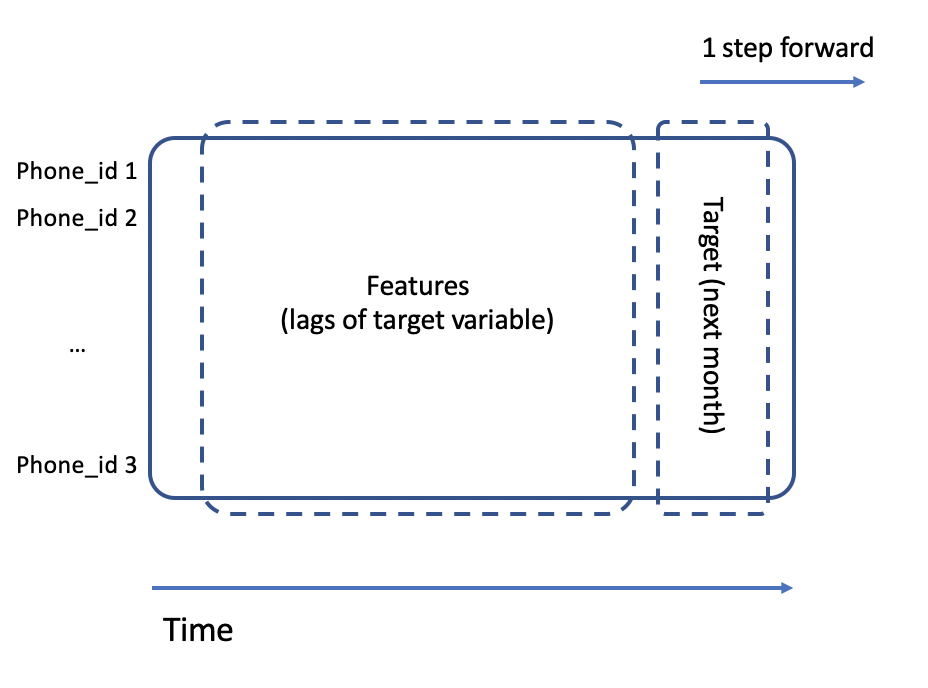

In [191]:
# from IPython.display import Image
# Image(filename='img1.png', width = 500, height = 500)

### DATA PREP

In [2]:
data_dir = '/Users/mmatskevichus/Downloads/ngwl-predict-customer-churn/'

In [3]:
### READ TEST DATA 

df_test = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'), nrows = None, sep = ';', dtype = {'Id': np.str})
df_test['order_completed_at'] = pd.to_datetime('2020-09-01')

df_test['train_valid_split'] = 'test'
df_test = df_test.drop(columns = ['Predicted'])
df_test = df_test.rename(columns = {'Id': 'phone_id'})

test_ids = df_test['phone_id'].unique()

In [4]:
### READ TRAIN DATA

df_train = pd.read_csv(os.path.join(data_dir, 'train', 'train.csv'), nrows = None, dtype = {'phone_id': np.str})
df_train['order_completed_at'] = df_train['order_completed_at'].apply(lambda x: str(x) + '-01')
df_train['order_completed_at'] = pd.to_datetime(df_train['order_completed_at'])

In [5]:
### MERGE TRAIN - TEST 

df_train_test = df_train.merge(df_test, on = ['phone_id', 'order_completed_at'], how = 'outer')

In [6]:
### SPLIT IDs FOR VALID (80% TRAIN, 20% TEST- randomly) 

np.random.seed(42)
train_frac = 0.8
puids_list = df_train_test['phone_id'].unique()
n = int(train_frac * len(df_train_test['phone_id'].unique()))
np.random.shuffle(puids_list)

train_puids = puids_list[:n]
valid_puids = puids_list[n:]

### FEATURE SET

In [7]:
train_f = pd.pivot(df_train_test[df_train_test['phone_id'].isin(train_puids)], 
                   index='phone_id', columns='order_completed_at', values='target').reset_index().fillna(-1)

valid_f = pd.pivot(df_train_test[df_train_test['phone_id'].isin(valid_puids)], 
                   index='phone_id', columns='order_completed_at', values='target').reset_index().fillna(-1)

In [8]:
train_f.columns =  ['phone_id'] + ['lag_' + str(x) for x in range(8)]
valid_f.columns =  ['phone_id'] + ['lag_' + str(x) for x in range(8)]

In [9]:
features_list = train_f.iloc[:, 1:-2].columns.tolist()
target = train_f.iloc[:,-2:-1].columns.tolist()[0]

In [10]:
print('Features:')
print(features_list)
print('Target')
print(target)

Features:
['lag_0', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5']
Target
lag_6


In [11]:
print('Train set featues')
train_f[features_list].head() 

Train set featues


,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5
0,-1.0,-1.0,-1.0,-1.0,1.0,0.0
1,-1.0,-1.0,-1.0,-1.0,1.0,1.0
2,-1.0,-1.0,-1.0,-1.0,1.0,1.0
3,-1.0,-1.0,-1.0,-1.0,1.0,0.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,1.0


In [12]:
print('Train set target')
train_f[target].head() 

Train set target


0    1.0
1    1.0
2    0.0
3    0.0
4    0.0
Name: lag_6, dtype: float64

In [13]:
### Separate users wo history (to add them after)

to_add = train_f[train_f[target] == -1]
to_add_valid = valid_f[valid_f[target] == -1]

train_f = train_f[train_f[target] !=-1]
valid_f = valid_f[valid_f[target] !=-1]

### Params tuning

In [14]:
### Metric func for Bayesian opt.

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

In [15]:
dtrain = xgb.DMatrix(train_f[features_list], label=train_f[target])

def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1}
    
    cv_result = xgb.cv(params, dtrain, num_boost_round=10, nfold=5, feval = f1_eval)
    
    print(cv_result['test-f1_err-mean'].iloc[-1])
    
    return cv_result['test-f1_err-mean'].iloc[-1]

xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 20),
                                             'gamma': (0, 1),
                                             'learning_rate':(0,1),
                                             'n_estimators':(100,300)
                                            })


In [16]:
xgb_bo.maximize(n_iter=3, init_points=5, acq='ei')

# params = xgb_bo.max['params']
# print(params)

# params['max_depth']= int(params['max_depth'])
# params['n_estimators']= int(params['n_estimators'])

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... |
-------------------------------------------------------------------------
0.2915214
|  1        |  0.2915   |  0.8856   |  0.4817   |  3.558    |  215.0    |
0.26982019999999995
|  2        |  0.2698   |  0.3432   |  0.616    |  13.43    |  221.9    |
0.29164059999999997
|  3        |  0.2916   |  0.8055   |  0.02488  |  3.517    |  235.4    |
0.2698658
|  4        |  0.2699   |  0.9917   |  0.9149   |  18.69    |  233.8    |
0.2692636
|  5        |  0.2693   |  0.331    |  0.149    |  15.94    |  299.7    |
0.29096520000000003
|  6        |  0.291    |  1.0      |  1.0      |  3.0      |  100.0    |
0.29164059999999997
|  7        |  0.2916   |  0.991    |  0.4617   |  3.008    |  145.2    |
0.2957116
|  8        |  0.2957   |  0.9326   |  0.9202   |  3.128    |  263.1    |


In [17]:
### Params we selected after several iterations 

params = {'gamma': 0.9302133048169021, 'max_depth': 3.092595410908883, 'n_estimators': 199.64541935593675, 'learning_rate': 0.1463151161288383}
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

In [18]:
### Train classif.

classifier2 = xgb.XGBClassifier(**params).fit(train_f[features_list], train_f[target])
pred = classifier2.predict(valid_f[features_list])
valid_f['proba'] = classifier2.predict_proba(valid_f[features_list])[:, 1]
valid_f['pred'] =  valid_f['proba'].apply(lambda x: 1 if x > 0.3 else 0)

In [19]:
### Check metric on the valid set
print('F1-score on valid:')
f1_score(y_pred=valid_f['pred'].values , y_true=valid_f[target].values)

F1-score on valid:


0.7364059089615032

### Prep data for pred 

In [20]:
# shift feature window 1 step forward + rename features for the model

lag_remove, lag_add = 'lag_0', 'lag_6'
features_list_new = features_list[1:] + [lag_add]

In [21]:
features_list_new

['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6']

In [22]:
train_f_pred = train_f[features_list_new]
train_f_pred.columns = ['lag_' + str(x) for x in range(len(features_list_new))] 

valid_f_pred = valid_f[features_list_new]
valid_f_pred.columns = ['lag_' + str(x) for x in range(len(features_list_new))]

In [23]:
pred_train_new = classifier2.predict_proba(train_f_pred)[:, 1]
pred_valid_new = classifier2.predict_proba(valid_f_pred)[:, 1]


In [24]:
train_f['pred_pred'] = pred_train_new
valid_f['pred_pred'] = pred_valid_new

In [25]:
### concat with separated piece of data

new = pd.concat([train_f, valid_f, pd.DataFrame(to_add['phone_id']), pd.DataFrame(to_add_valid['phone_id'])])
new = new[['phone_id', 'pred_pred']]

In [26]:
test_only = new[new['phone_id'].isin(test_ids)]
test_only = test_only.fillna(1)

test_only['pred_pred'] = test_only['pred_pred'].apply(lambda x: 1 if x > 0.5 else 0)

In [27]:
subm = pd.read_csv(os.path.join(data_dir, 'sample_submission.csv'), sep =';', dtype = {'Id': np.str})
subm = subm.rename(columns = {'Id': 'phone_id'})

subm = subm.merge(test_only, on = 'phone_id')
subm['Predicted'] = subm['pred_pred']

In [28]:
subm = subm.rename(columns ={'phone_id': 'Id'})
subm['Predicted'] = subm['Predicted'].astype('bool') 

In [29]:
subm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214609 entries, 0 to 214608
Data columns (total 3 columns):
Id           214609 non-null object
Predicted    214609 non-null bool
pred_pred    214609 non-null int64
dtypes: bool(1), int64(1), object(1)
memory usage: 5.1+ MB


In [163]:
subm[['Id', 'Predicted']].to_csv('xxxx_submition_dig_deeper.csv', sep =',', index = None)